In [1]:
import random
import numpy as np
import torch

seed = 17


def set_seed(seed: int):
  """Set the random seed for reproducibility."""
  random.seed(seed)  # Python random
  np.random.seed(seed)  # NumPy random
  torch.manual_seed(seed)  # PyTorch CPU
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)  # PyTorch all GPUs


def worker_init_fn(worker_id):
  """Worker initialization function to set seed for each worker."""
  # Set the seed for each worker based on the worker ID and the main seed
  set_seed(seed + worker_id)

In [2]:
set_seed(seed)

In [ ]:
from typing import List

import torch
import torch.nn.functional as F
from torchdiffeq import odeint

from unet import Unet


class ConditionalOTFlowMatching:
  def __init__(
      self,
      unet: Unet,
      input_shape: List[int],
      sigma_min: float,
  ):
    self.v = unet
    self.input_shape = input_shape
    self.sigma_min = sigma_min

  def cond_psi(
      self,
      t: torch.Tensor,
      x_0: torch.Tensor,
      x_1: torch.Tensor
  ) -> torch.Tensor:
    b, *_ = x_0.shape
    return (
        (1 - (1 - self.sigma_min) * t.view((b, 1, 1, 1))) * x_0 +
        t.view((b, 1, 1, 1)) * x_1
    )

  def u(self, x_0: torch.Tensor, x_1: torch.Tensor) -> torch.Tensor:
    return x_1 - (1 - self.sigma_min) * x_0

  def training_step(self, x, c):
    # x: (b, c, h, w) [images]
    # c: (b, ) [labels]
    b, *_ = x.shape
    # Sample time
    t = torch.rand((b, ), device=x.device)
    # Set conditional flow endpoints
    x_0 = torch.randn_like(x)
    x_1 = x
    # Push x_0 through conditional flow
    psi = self.cond_psi(t, x_0, x_1)
    # Regress the ground truth conditional flow field
    v = self.v(psi, t, c)
    u = self.u(x_0, x_1)
    return F.mse_loss(v, u)

  @torch.inference_mode()
  def sample(
      self,
      c: torch.Tensor,
      w: float = 1.0,
      num_ode_steps: int = 100,
      return_trajectory: bool = False
  ):
    # c: (b, ) [labels]
    b = c.shape[0]
    # Sample some noise
    x_0 = torch.randn([b] + self.input_shape, device=c.device)
    # Solve the flow ODE system
    x_t = odeint(
        lambda t, x: (
            (1 - w) * self.v(x, t * torch.ones((b, ), device=x.device)) +
            w * self.v(x, t * torch.ones((b, ), device=x.device), c)
        ),
        x_0,
        torch.linspace(0, 1,  num_ode_steps, device=c.device),
        rtol=1e-5,
        atol=1e-5,
        method="dopri5"  # taken from the paper
    )
    if return_trajectory:
      return x_t
    else:
      # Grab the final state
      x_1 = x_t[-1, ...]
      return x_1

In [4]:
device = torch.device(f"cuda:{0}")

In [5]:
num_classes = 10

In [6]:
from unet import Unet

v = Unet(
    channels=64,
    channel_mults=[1, 2, 4],
    in_channels=1,
    num_classes=10,
    class_conditional=True,
    class_dropout_prob=0.2,
).to(device)

In [7]:
v.load_state_dict({
    k.replace('module.', ''): v
    for k, v in torch.load('v128.pth', weights_only=True).items()
})

<All keys matched successfully>

In [8]:
cfm = ConditionalOTFlowMatching(
    unet=v,
    input_shape=[1, 28, 28],
    sigma_min=0.002,
)

In [9]:
batch_size = 32
num_epochs = 5
lr = 3e-4

In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    prefetch_factor=2,
    worker_init_fn=worker_init_fn
)

In [11]:
from torch.optim import AdamW
from torch.amp import autocast, GradScaler

optimizer = AdamW(v.parameters(), lr=lr)
scaler = GradScaler()

In [12]:
from tqdm import tqdm

# Training loop with tqdm
for epoch in range(num_epochs):
  total_loss = 0
  # Wrap the DataLoader with tqdm for a progress bar
  progress_loader = tqdm(
      train_loader,
      desc=f'epoch [{epoch+1}/{num_epochs}]',
      leave=False
  )
  for x, c in progress_loader:
    # Move inputs to the device
    x = x.to(device)
    c = c.to(device)
    # Compute the loss
    cfm.v.train()
    with autocast(device_type="cuda", dtype=torch.bfloat16):
      loss = cfm.training_step(x, c)
    # Backprop
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    # Update total loss and display it in the progress bar
    total_loss += loss.item()
    progress_loader.set_postfix(loss=loss.item())

  # Print the average loss for this epoch
  avg_loss = total_loss / len(train_loader)
  print(f"epoch [{epoch+1}/{num_epochs}], avg loss: {avg_loss:.4f}")

epoch [1/5], avg loss: 0.1655


epoch [2/5], avg loss: 0.1636


epoch [3/5], avg loss: 0.1622


epoch [4/5], avg loss: 0.1618


epoch [5/5], avg loss: 0.1610


In [13]:
torch.save(cfm.v.state_dict(), 'v.pth')

In [14]:
torch.save(optimizer.state_dict(), 'w.pth')

In [15]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


def plot_samples(
    num_classes: int,
    num_samples_per_class: int,
    num_ode_steps: int,
    w: float,
    device: torch.device
):
  c = (
      torch.arange(num_classes)
      .repeat_interleave(num_samples_per_class)
      .to(device)
  )
  samples = cfm.sample(c, w, num_ode_steps)
  # Create a grid of images
  samples_grid = make_grid(
      samples.reshape([num_classes * num_samples_per_class, 1, 28, 28]),
      nrow=num_samples_per_class,
      normalize=True
  )
  return samples_grid

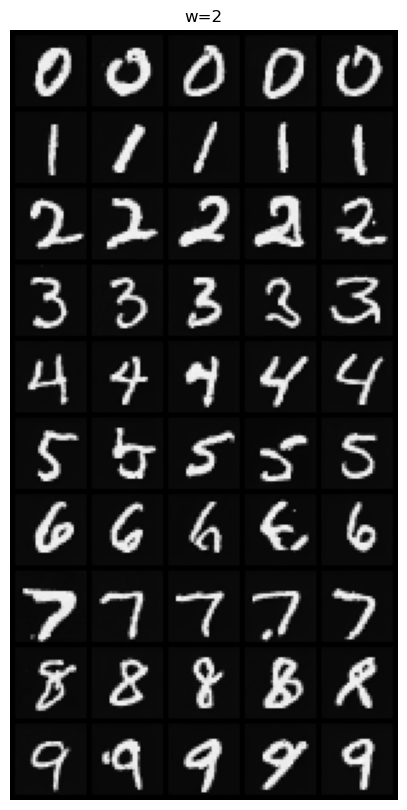

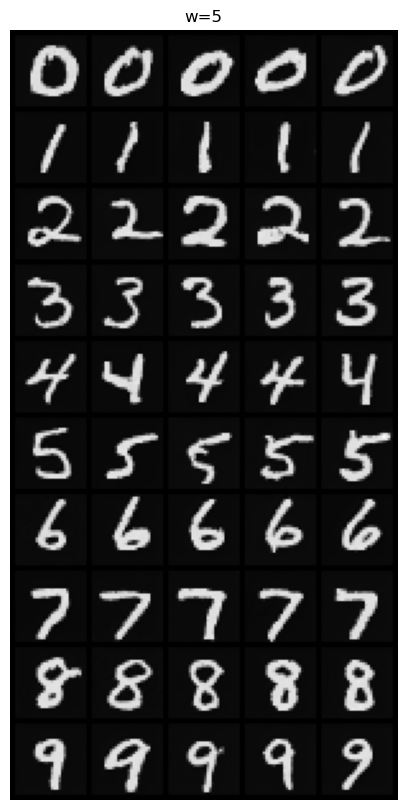

In [16]:
num_ode_steps = 100

for w in [2, 5]:
  grid = plot_samples(
      num_classes=num_classes,
      num_samples_per_class=5,
      num_ode_steps=num_ode_steps,
      w=w,
      device=device
  )
  # Plot the grid
  plt.figure(figsize=(10, 10))
  # Permute to (H, W, C) for matplotlib
  plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
  plt.title(f"w={w}")
  plt.axis('off')  # Turn off axis
  plt.show()

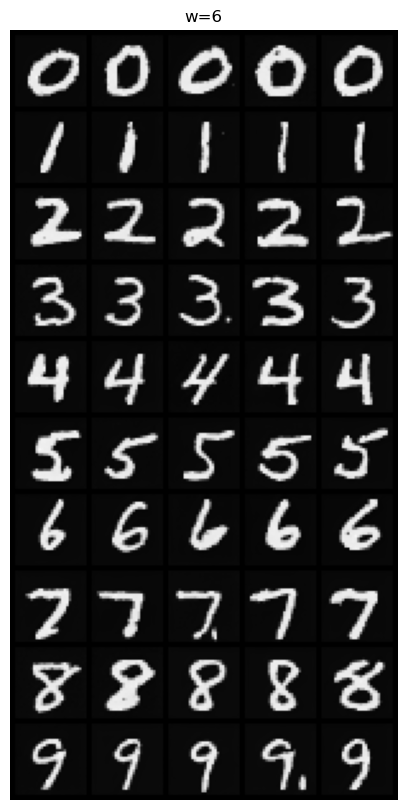

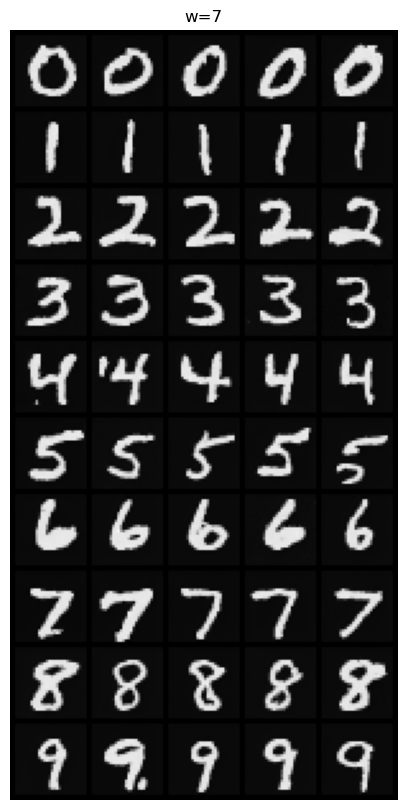

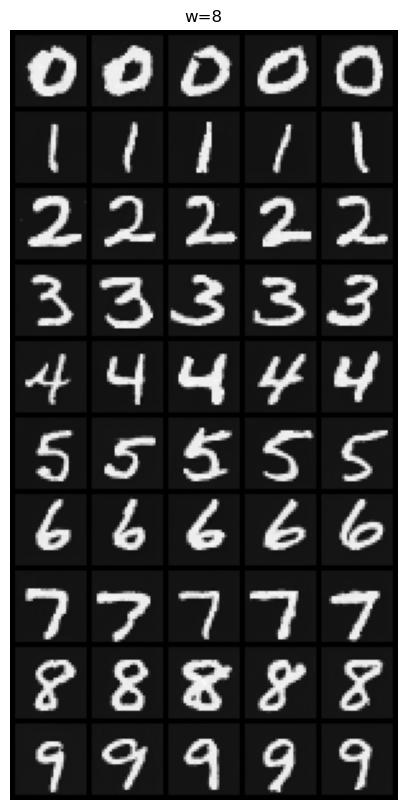

In [17]:
num_ode_steps = 100

for w in [6, 7, 8]:
  grid = plot_samples(
      num_classes=num_classes,
      num_samples_per_class=5,
      num_ode_steps=num_ode_steps,
      w=w,
      device=device
  )
  # Plot the grid
  plt.figure(figsize=(10, 10))
  # Permute to (H, W, C) for matplotlib
  plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
  plt.title(f"w={w}")
  plt.axis('off')  # Turn off axis
  plt.show()

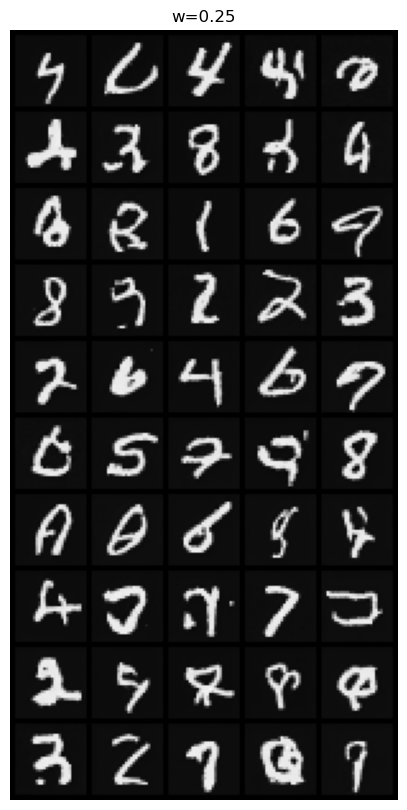

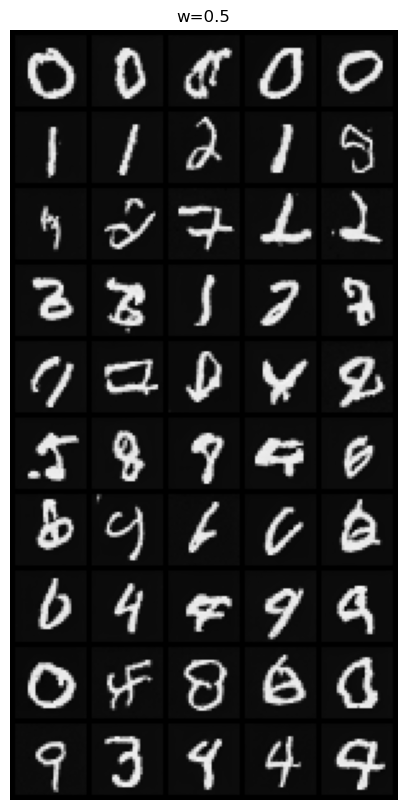

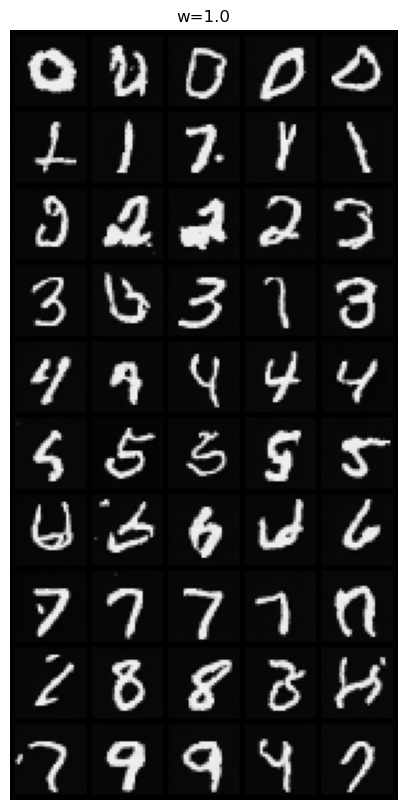

In [18]:
num_ode_steps = 100

for w in [0.25, 0.5, 1.0]:
  grid = plot_samples(
      num_classes=num_classes,
      num_samples_per_class=5,
      num_ode_steps=num_ode_steps,
      w=w,
      device=device
  )
  # Plot the grid
  plt.figure(figsize=(10, 10))
  # Permute to (H, W, C) for matplotlib
  plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
  plt.title(f"w={w}")
  plt.axis('off')  # Turn off axis
  plt.show()